### Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet
%pip install cloudpickle --quiet --quiet

### TODO
+ Have the readme suggest how to make a new conda environment and install jupyter lab

### Run Demo

In [1]:
from typing import Sequence

import torch
import coba as cb

from AbstractClasses import LossPredictor, ReferencePolicy
from CauchyNetwork import CauchyNetwork

class UniformReferencePolicy(ReferencePolicy):
    def __init__(self, batch_size:int = 100):
        self._batch_size = batch_size
    def sample(self, context):
        while True: yield torch.rand(self._batch_size).tolist()

class MyLossPredictor(LossPredictor):
    def __init__(self, *, numrff:int, sigma:float, in_features:int, opt_factory, sched_factory) -> None:
        self._cauchy_net = CauchyNetwork(numrff,sigma,in_features)
        self.loss        = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.opt         = opt_factory(self._cauchy_net.parameters())
        self.scheduler   = sched_factory(self.opt)

    @property
    def params(self):
        return self._cauchy_net.params

    #one context many actions (add more documentation)
    def predict(self, context: torch.Tensor, actions: Sequence[float]) -> Sequence[float]:
        with torch.no_grad():
            context = context.expand(len(actions),-1)
            actions = torch.tensor(actions).unsqueeze(1)
            return self._cauchy_net.loss(torch.cat([context,actions],dim=1))

    #these are triples in parallel arrays (TODO: cleanup documentation)
    def learn(self, contexts: torch.Tensor, actions: Sequence[float], losses: Sequence[float]) -> None:

        if contexts.dim() == 1: contexts = contexts.unsqueeze(0)
        actions = torch.tensor(actions).unsqueeze(1)

        X = torch.cat([contexts,actions],dim=1)
        y = torch.tensor(losses)

        self.opt.zero_grad()
        yhat = self._cauchy_net.pre_logits(X).squeeze(1)
        loss = self.loss(yhat,y)
        loss.mean().backward()
        self.opt.step()
        self.scheduler.step()

        with torch.no_grad():
            optimal_loss = self.loss(torch.logit(y),y)
            cb.CobaContext.learning_info['loss_prediction_loss'] = loss.tolist()
            cb.CobaContext.learning_info['loss_prediction_regret'] = (loss-optimal_loss).tolist()

2023-07-20 02:24:30 -- Experiment Started
2023-07-20 02:24:30 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-20 02:24:30 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-20 02:24:30 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-20 02:24:30 -- Peeking at Environment 0... (0.19 seconds) (completed)
2023-07-20 02:24:31 -- Evaluating Learner 0 on Environment 0... (1.06 seconds) (completed)
2023-07-20 02:24:31 -- Experiment Finished


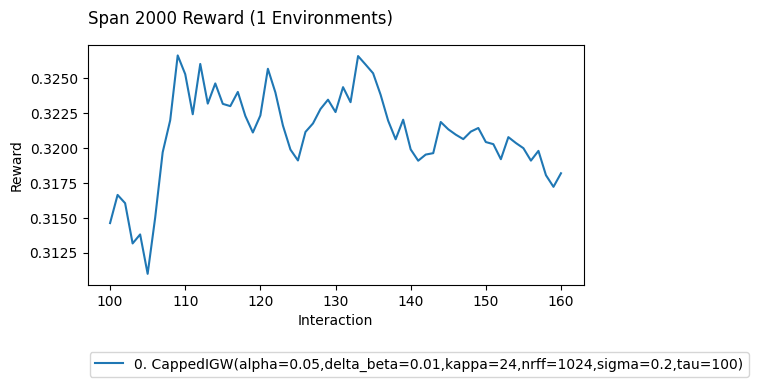

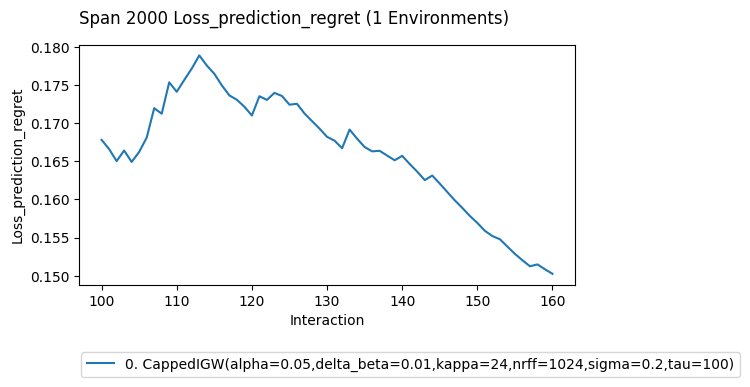

In [3]:
import torch
import coba as cb
import numpy as np
from CappedIGW import CappedIGW
from DataCleaning import MakeLosses, Tensorize

#these dimensions are specific to openml dataset 41540
context_dim, action_dim = 22, 1
tzero = 100
gamma_tzero = 1e-4
lr = 1e-2
batch_size = 8
n_batches = 2_500

fhat = MyLossPredictor(
    numrff=1024,
    sigma=2e-1,
    in_features=context_dim+action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:(1+t/tzero)**(-.5))
)

#this is the directory where the
#openml data will be cached on disk
cb.Environments.cache_dir('.coba_cache')

env = cb.Environments.from_openml(data_id=41540,take=batch_size*n_batches).scale().filter(MakeLosses()).repr('onehot').batch(batch_size).filter(Tensorize())
lrn = CappedIGW(mu=UniformReferencePolicy(), 
                fhat=fhat, 
                gamma_sched=lambda t:(1+t/tzero)**(.5))

result = cb.Experiment(env,lrn).run()
result.plot_learners(y='reward'                , span=2_000, xlim=(100,None))
result.plot_learners(y='loss_prediction_regret', span=2_000, xlim=(100,None))